In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

In [22]:
!pip install shap
import shap
#clear the output 
from IPython.display import clear_output
clear_output(wait=False)

In [3]:
df = pd.read_csv('./dataset/data_file.csv', sep=',')

categorical_columns = ['Machine', 'MajorImageVersion', 'MajorOSVersion', 'MajorLinkerVersion', 'MinorLinkerVersion', 'DllCharacteristics', 'NumberOfSections']
df[categorical_columns] = df[categorical_columns].astype('category')

binary_columns = ['Benign', 'BitcoinAddresses']

numeric_columns = df.select_dtypes(include=['int64']).columns.difference(binary_columns)

df.drop(columns=['FileName', 'md5Hash'], inplace=True)

df['LinkerVersion'] = df['MajorLinkerVersion'].astype(str) + '.' + df['MinorLinkerVersion'].astype(str)
df['LinkerVersion'] = df['LinkerVersion'].astype('category')
df.drop(columns=['MajorLinkerVersion', 'MinorLinkerVersion'], inplace=True)

categorical_columns = [col for col in categorical_columns if col not in ['MajorLinkerVersion', 'MinorLinkerVersion']]
categorical_columns.append('LinkerVersion')

df.drop(columns=['BitcoinAddresses'], inplace=True)

### AI models explainability

As we've seen before, for our classification we used Logistic Regression and Random Forest, which have notable differences in terms of explainability. In fact, Linear Regression is a white box model, meaning that is easily explainable in terms of the coefficients used to weight the features. On the other hand, Random Forest is a black box model,  meaning that we need post-hoc techniques to explain those models such as SHAP values or LIME.
Since we've seen that categorical features offer a very good balance between performances and computational effort, we're going to explain those models.

#### Logistic Regression Explainability


##### Logistic Regression Explainability using coefficients

For Logistic Regression it's possible to see the coefficients given to each feature to see the importance of each one of them

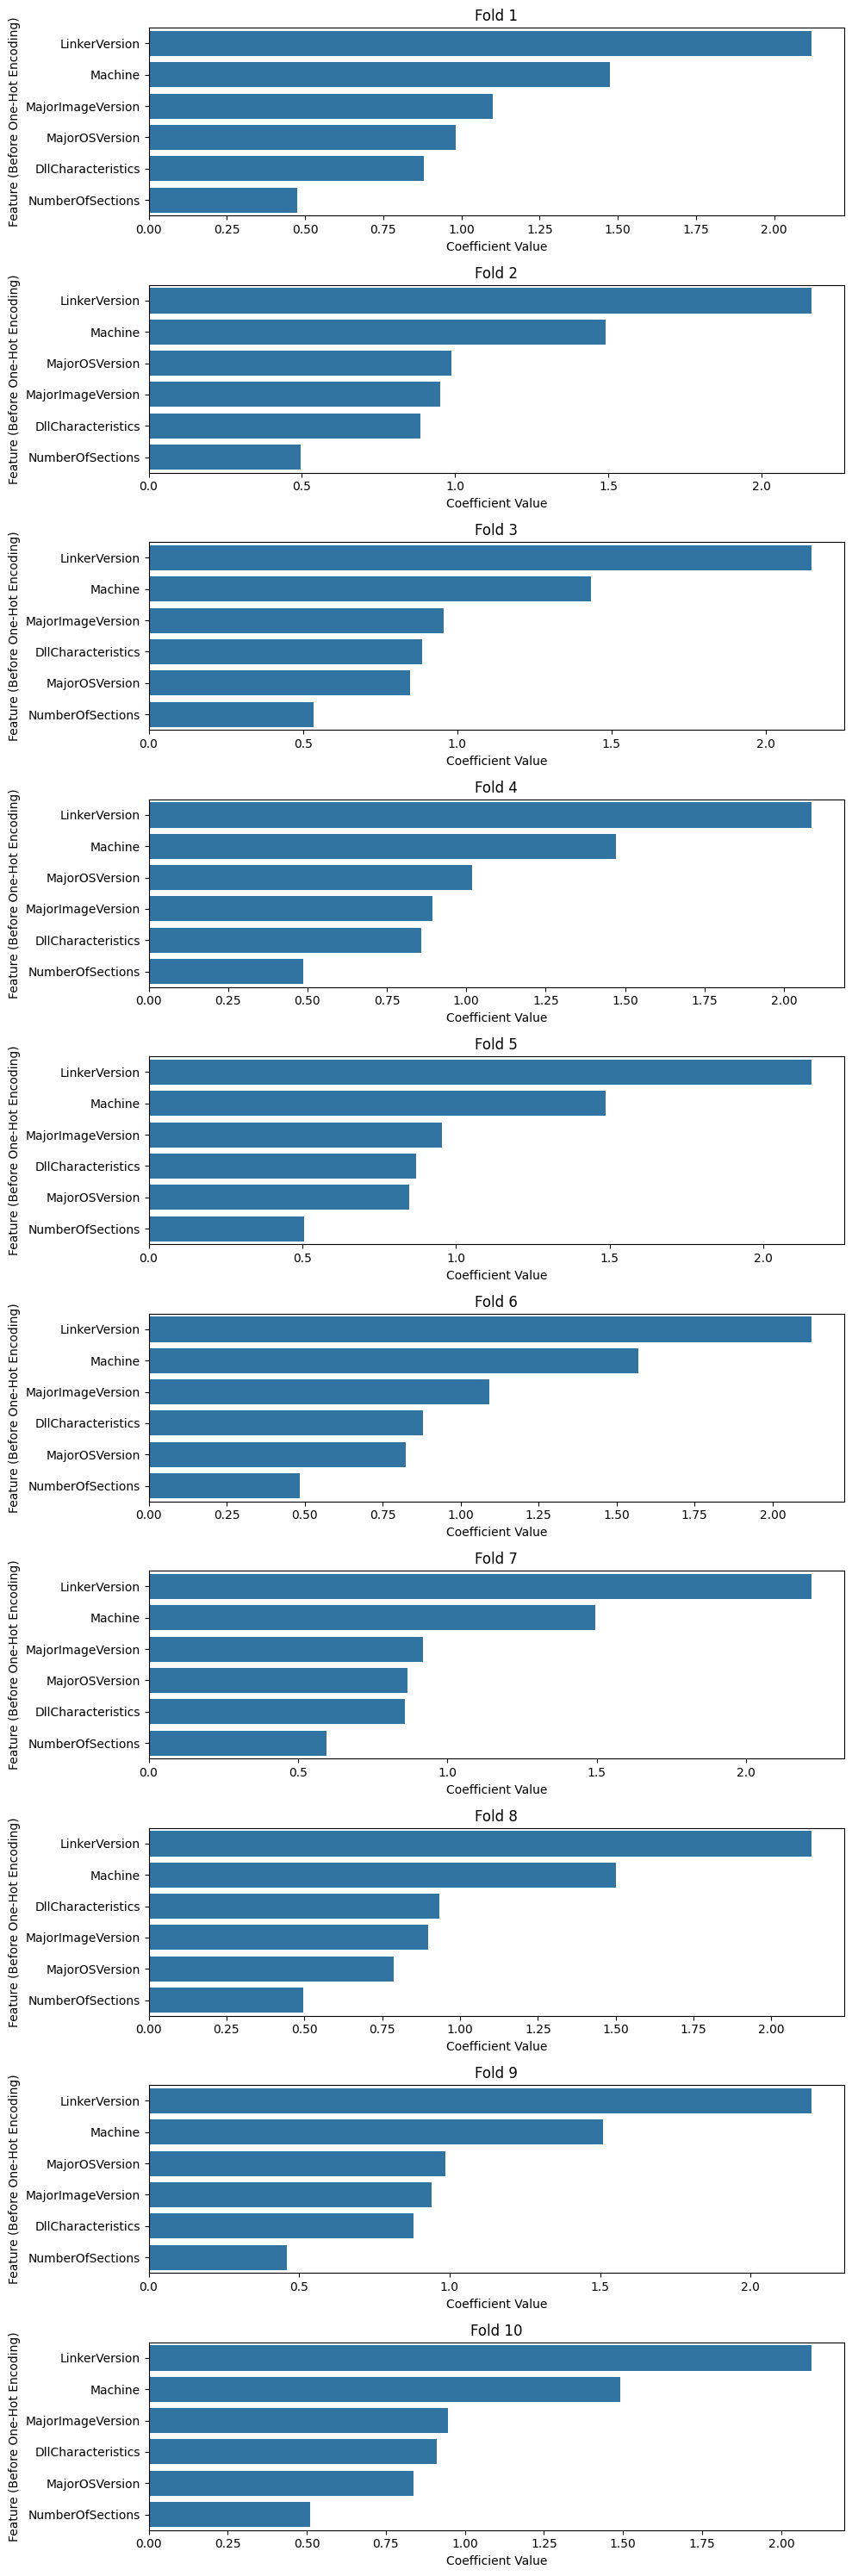

In [20]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 30))

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Extract model coefficients
    coefficients = pipeline.named_steps['classifier'].coef_[0]

    # Extract the one-hot encoded feature names
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat_transform']
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

    # Create a mapping from one-hot encoded features to their original categorical feature
    feature_coefficients = {}

    for feature in categorical_columns:
        # Find all one-hot encoded features that belong to the current categorical feature
        matching_features = [f for f in ohe_feature_names if f.startswith(feature)]
    
        # Get their indices in the coefficient array
        indices = [ohe_feature_names.tolist().index(f) for f in matching_features]

        # Aggregate coefficients (e.g., by taking the mean)
        feature_coefficients[feature] = np.mean([coefficients[i] for i in indices if coefficients[i] > 0])

    # Print the coefficients for this fold
    # print(f"Fold {i + 1}:")
    # for feature, coef in feature_coefficients.items():
    #     print(f"  Feature: {feature}, Coefficient: {coef}")
    # print("\n")  # Empty line for readability

    # Plot for this fold in the appropriate subplot
    coef_df_fold = pd.DataFrame.from_dict(feature_coefficients, orient='index', columns=['Coefficient'])
    coef_df_fold = coef_df_fold.sort_values(by='Coefficient', ascending=False)

    # Plot on the appropriate axis (subplot)
    ax = axes[i]
    sns.barplot(x=coef_df_fold['Coefficient'], y=coef_df_fold.index, ax=ax)
    ax.set_title(f"Fold {i + 1}")
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature (Before One-Hot Encoding)")

plt.tight_layout()
plt.show()


The OneHotEncoder is accessed through the pipeline's preprocessor step. Using the get_feature_names_out method, we retrieve the names of the one-hot encoded features that correspond to the original categorical columns.

Next, we extract the coefficients from the Logistic Regression model. These coefficients reflect the influence of each feature (or its transformed counterpart) on the model’s predictions. Since we are dealing with a binary classification problem, we focus on the coefficients for the positive class (coef_[0]).

To map the one-hot encoded features back to their original categorical features, we perform the following steps:

For each categorical feature, we identify the one-hot encoded features that are derived from it by checking which encoded feature names begin with the name of the original categorical feature.
We then retrieve the corresponding coefficients and aggregate them by performing their average.
This process allows us to assess the relative importance of each original categorical feature by examining the aggregated coefficients, providing a clearer view of how each feature contributes to the model's predictions.

From the graph we can see that the attributes Machine, MajorOSVersion and NumberOfSections are the most important when considering the classification between Benign and Malign.

##### Logistic Regression Explainability using SHAP

SHAP is a popular method for interpretable machine learning, based on game theory. It assigns Shapley values to each feature in a model, quantifying its contribution to a particular prediction. SHAP is widely used because:

It provides a consistent and fair way to distribute feature importance.
It explains both global feature importance (how features influence predictions overall) and local explanations (why a model made a specific prediction).
It works well with tree-based models, deep learning, and linear models like Logistic Regression.

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0     1.382431           0.004004       -0.059648           -0.001384   
1     1.382431           0.038855        0.097385            0.052565   
2    -0.303461           0.004004        0.097385            0.052565   
3     1.382431          -0.017819       -0.006266           -0.043683   
4     1.382431           0.038855        0.097385           -0.030597   
...        ...                ...             ...                 ...   
6244 -0.303461           0.010857       -0.006266           -0.043683   
6245 -0.303461          -0.017819       -0.006266           -0.050844   
6246 -0.303461           0.030092       -0.006266           -0.043683   
6247 -0.303461           0.003451       -0.043361           -0.030597   
6248 -0.303461          -0.017819       -0.006266           -0.043683   

      NumberOfSections  LinkerVersion  
0            -0.041203       0.019327  
1            -0.029042      -0.005407  
2  

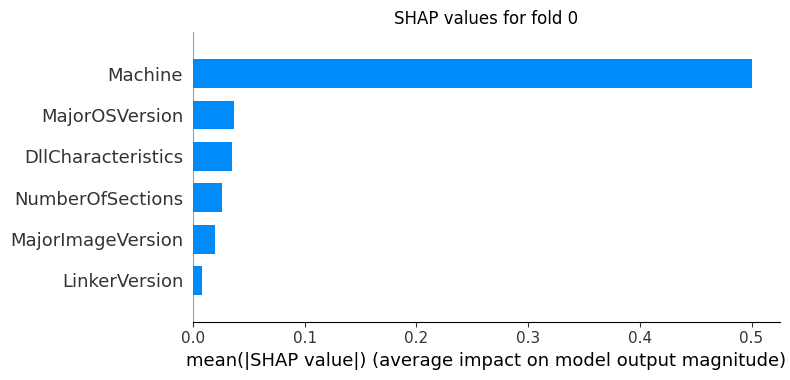

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0     1.037241           0.005623        0.107141            0.009923   
1    -0.345747          -0.016392        0.002820            0.047026   
2    -0.345747          -0.016392        0.002820            0.070489   
3     1.037241           0.034437        0.107141           -0.019027   
4     1.037241           0.005623       -0.045831            0.009923   
...        ...                ...             ...                 ...   
6244 -0.345747          -0.016392        0.002820           -0.039411   
6245 -0.345747           0.034437        0.002820           -0.025015   
6246 -0.345747           0.027374        0.002820           -0.032721   
6247 -0.345747          -0.016392        0.002820           -0.032721   
6248 -0.345747          -0.009313       -0.045831           -0.032721   

      NumberOfSections  LinkerVersion  
0            -0.036662       0.006151  
1             0.041693      -0.002664  
2  

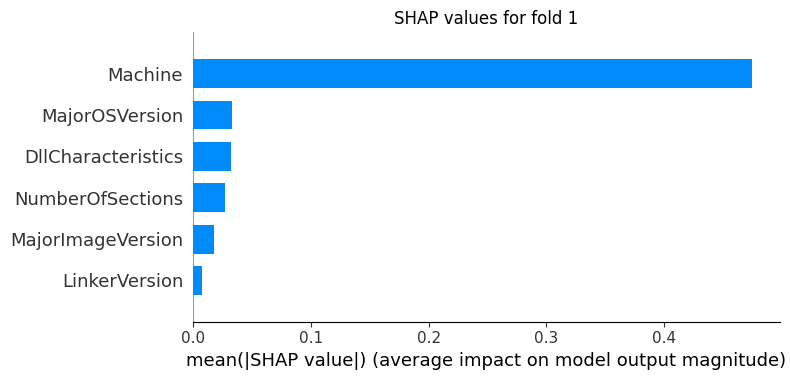

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0     1.118604           0.000582       -0.057536            0.008411   
1     1.118604           0.000582       -0.057536            0.008791   
2     1.118604           0.000582       -0.057536            0.008791   
3    -0.550954          -0.021362       -0.007697            0.046208   
4    -0.550954           0.000582       -0.057536            0.044054   
...        ...                ...             ...                 ...   
6244 -0.550954          -0.021362       -0.007697           -0.034715   
6245 -0.550954           0.022296       -0.007697           -0.034715   
6246 -0.550954           0.005730       -0.007697           -0.034715   
6247 -0.550954          -0.021362       -0.043961            0.001192   
6248 -0.550954          -0.021362       -0.007697           -0.034715   

      NumberOfSections  LinkerVersion  
0             0.016901       0.018922  
1            -0.014646       0.018922  
2  

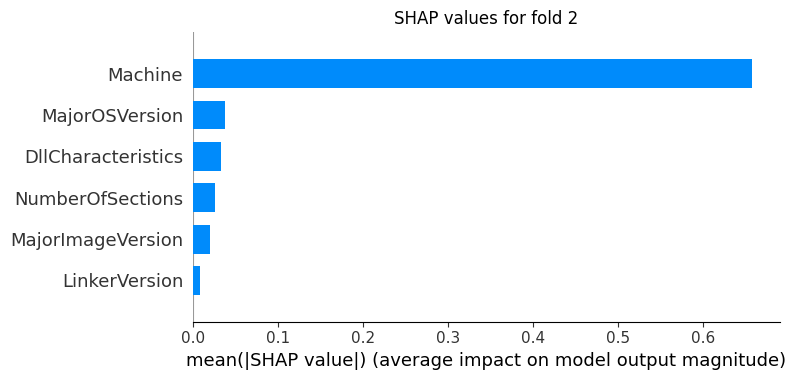

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0    -0.345651          -0.019545       -0.002215            0.041906   
1    -0.345651          -0.019545       -0.002215            0.041906   
2    -0.345651          -0.019545       -0.002215            0.041906   
3     1.039356           0.040688        0.108022            0.005603   
4     1.039356           0.040688        0.108022           -0.022978   
...        ...                ...             ...                 ...   
6244 -0.345651           0.070266       -0.048017           -0.036317   
6245 -0.345651           0.040688       -0.002215           -0.029427   
6246 -0.345651          -0.019545       -0.039080           -0.036317   
6247 -0.345651           0.029059       -0.002215           -0.036317   
6248 -0.345651           0.029059       -0.002215           -0.036317   

      NumberOfSections  LinkerVersion  
0             0.036878      -0.003622  
1             0.036878      -0.003622  
2  

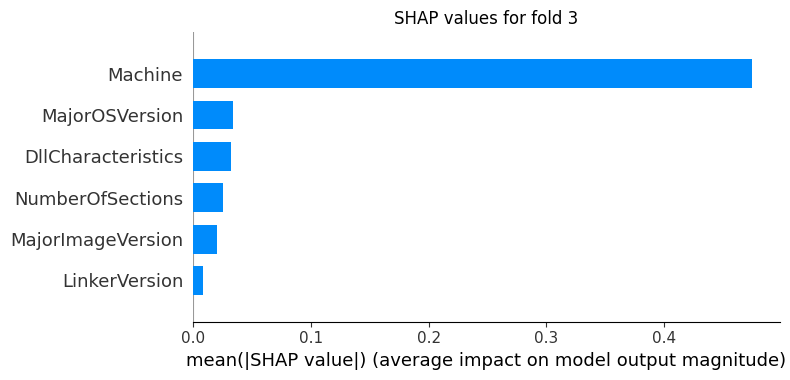

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0     1.059950           0.002427       -0.052376            0.004252   
1    -0.334721          -0.015592       -0.008189            0.040827   
2    -0.334721          -0.015592       -0.008189            0.040827   
3     1.059950           0.037664        0.099584           -0.024432   
4     1.059950           0.002427        0.099584            0.004252   
...        ...                ...             ...                 ...   
6244 -0.334721          -0.015592       -0.045036           -0.039367   
6245 -0.334721           0.026008       -0.008189           -0.039367   
6246 -0.334721          -0.015592       -0.045036           -0.004215   
6247 -0.334721          -0.015592       -0.008189           -0.039367   
6248 -0.334721          -0.015592       -0.045036           -0.039367   

      NumberOfSections  LinkerVersion  
0            -0.034806       0.018278  
1             0.037099      -0.003472  
2  

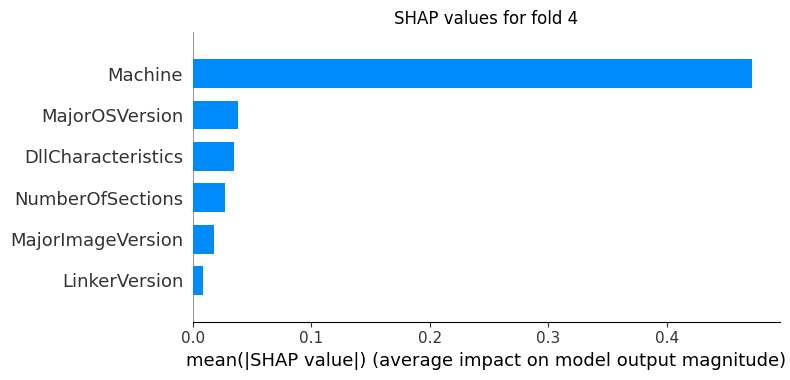

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0    -0.411774          -0.015619        0.005110            0.044814   
1    -0.411774          -0.015619        0.005110            0.044814   
2     1.058847           0.004529       -0.041182            0.008871   
3    -0.411774          -0.015619        0.005110            0.044814   
4    -0.411774          -0.015619        0.005110            0.068715   
...        ...                ...             ...                 ...   
6243 -0.411774          -0.015619        0.005110            0.044814   
6244 -0.411774          -0.015619       -0.030719           -0.026093   
6245 -0.411774          -0.015619        0.005110           -0.031758   
6246 -0.411774          -0.015619        0.005110           -0.020128   
6247 -0.411774          -0.015619        0.005110           -0.031758   

      NumberOfSections  LinkerVersion  
0             0.039709      -0.003568  
1             0.039709      -0.003568  
2  

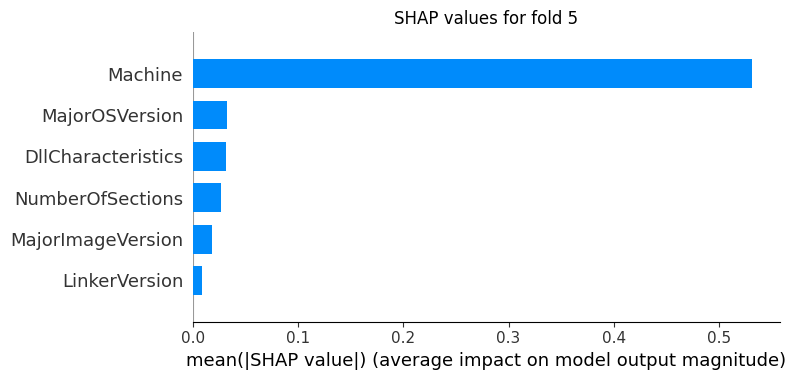

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0    -0.335572          -0.018020       -0.001401            0.040776   
1     1.062645           0.003785       -0.054128            0.004894   
2    -0.335572          -0.018020       -0.001401            0.040776   
3    -0.335572          -0.018020       -0.001401            0.040776   
4     1.062645           0.039841        0.108689           -0.002061   
...        ...                ...             ...                 ...   
6243 -0.335572          -0.018020       -0.040952           -0.034726   
6244 -0.335572          -0.018020       -0.001401           -0.034726   
6245 -0.335572          -0.018020       -0.001401           -0.034726   
6246 -0.335572          -0.018020       -0.040952           -0.034726   
6247 -0.335572           0.025551       -0.001401           -0.034726   

      NumberOfSections  LinkerVersion  
0             0.035703      -0.001392  
1            -0.046768       0.020400  
2  

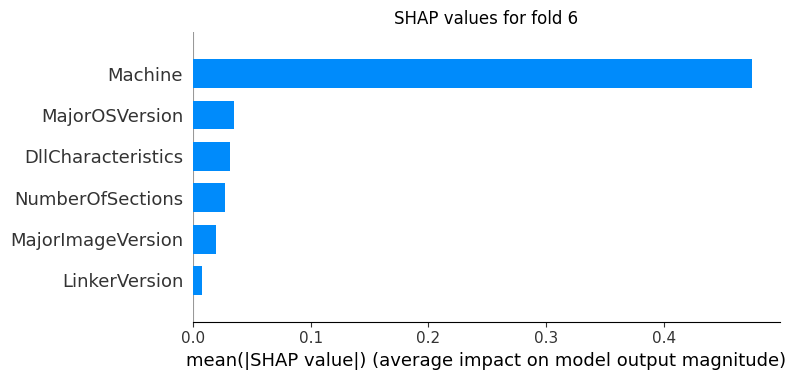

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0     1.067232           0.004850       -0.049777            0.008528   
1     1.067232           0.004850       -0.049777            0.008528   
2    -0.337021          -0.019646       -0.002058            0.047200   
3    -0.337021          -0.019646       -0.002058            0.071611   
4    -0.337021          -0.019646       -0.002058            0.071611   
...        ...                ...             ...                 ...   
6243 -0.337021          -0.019646       -0.039474           -0.027170   
6244 -0.337021          -0.019646       -0.002058           -0.040320   
6245 -0.337021          -0.019646       -0.002058           -0.034859   
6246 -0.337021          -0.019646       -0.002058           -0.040320   
6247 -0.337021           0.035380       -0.002058           -0.027170   

      NumberOfSections  LinkerVersion  
0            -0.024161       0.018355  
1            -0.037612       0.018355  
2  

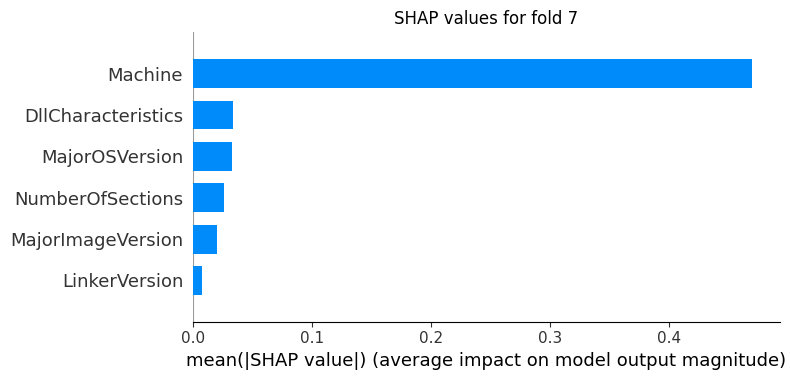

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0    -0.311103          -0.018812       -0.003243            0.041792   
1    -0.311103          -0.018812       -0.003243            0.019950   
2     1.103001           0.002995       -0.049728            0.005251   
3    -0.311103           0.002995        0.102961            0.059251   
4    -0.311103           0.026865       -0.003243           -0.038729   
...        ...                ...             ...                 ...   
6243 -0.311103          -0.018812       -0.043521           -0.030834   
6244 -0.311103          -0.018812       -0.003243           -0.038729   
6245 -0.311103          -0.018812       -0.003243           -0.038729   
6246 -0.311103          -0.018812       -0.003243           -0.002511   
6247 -0.311103          -0.018812       -0.043521           -0.030834   

      NumberOfSections  LinkerVersion  
0             0.037075      -0.001347  
1             0.037075      -0.001347  
2  

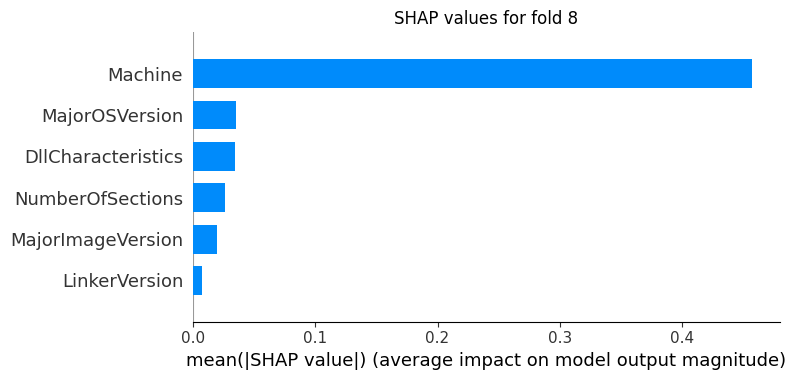

       Machine  MajorImageVersion  MajorOSVersion  DllCharacteristics  \
0    -0.335874          -0.016798       -0.005665            0.042996   
1    -0.335874          -0.016798       -0.005665            0.042996   
2    -0.335874          -0.016798       -0.005665            0.042996   
3     1.063601           0.002015       -0.053542            0.006084   
4     1.063601           0.038528        0.103385            0.060103   
...        ...                ...             ...                 ...   
6243 -0.335874          -0.016798       -0.040227            0.016467   
6244 -0.335874          -0.016798       -0.005665           -0.038169   
6245 -0.335874          -0.016798       -0.040227           -0.032435   
6246 -0.335874           0.028016       -0.005665           -0.038169   
6247 -0.335874          -0.016798       -0.040227           -0.032435   

      NumberOfSections  LinkerVersion  
0             0.036450      -0.002677  
1             0.036450      -0.002677  
2  

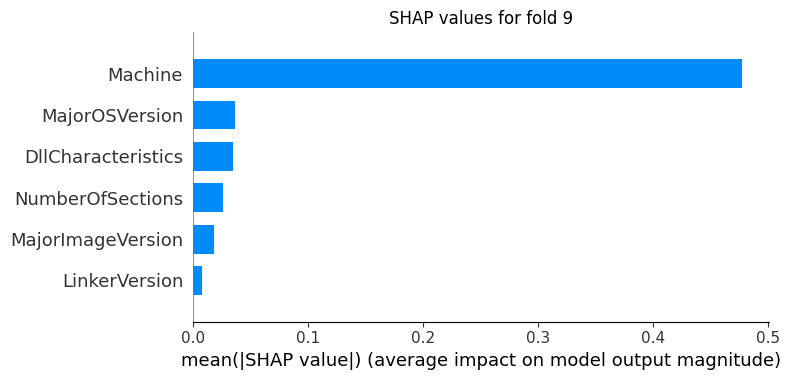

In [23]:
X = df[categorical_columns]  
y = df["Benign"]
 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transform", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)
 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
 


for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat_transform"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained LogisticRegression
    explainer = shap.Explainer(pipeline.named_steps["classifier"],pipeline.named_steps["preprocessor"].transform(X_test))
    shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_test))
 

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df = pd.DataFrame(shap_values.values, columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)

    # Initialization of dictionary to contain aggregate values 
    agg_shap_per_row = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature
            row_agg_shap[orig_feat] = row[enc_feats].mean()
            
        agg_shap_per_row.append(row_agg_shap)

    # Converts the list of aggregated results into a DataFrame
    agg_shap_df = pd.DataFrame(agg_shap_per_row)

    print(agg_shap_df)


    plt.title(f"SHAP values for fold {i}")
    shap.summary_plot(agg_shap_df.values, features=agg_shap_df.columns, plot_type="bar")
    plt.show()


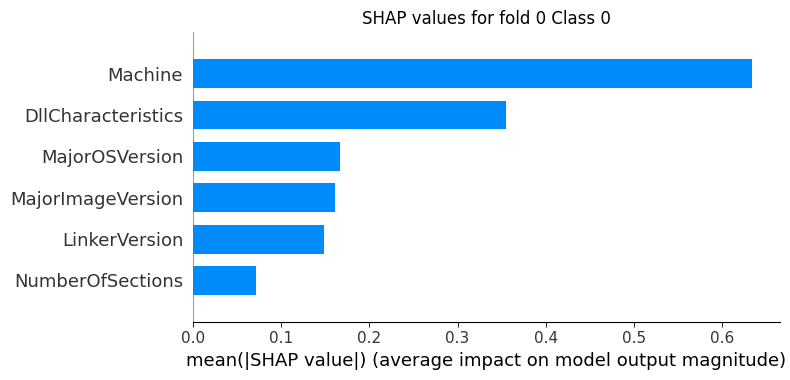

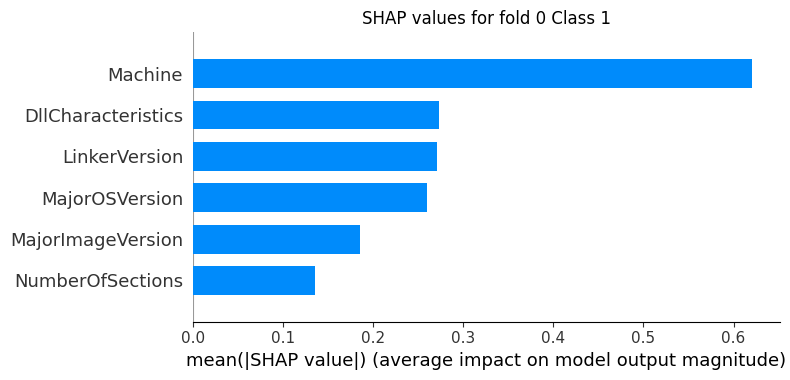

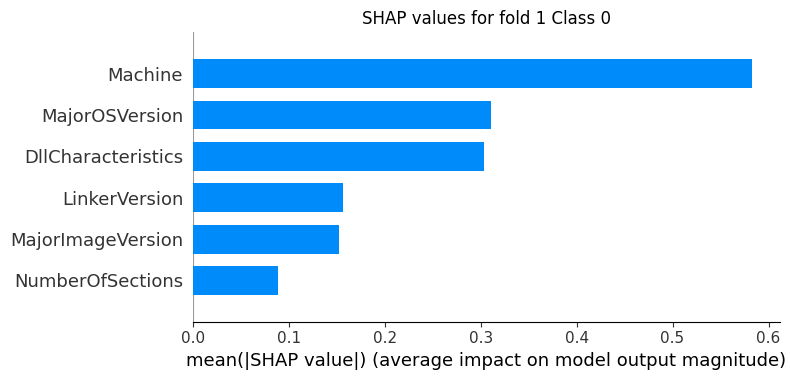

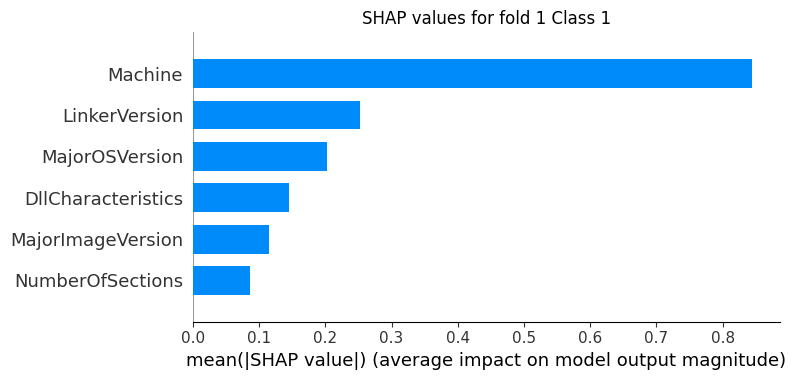

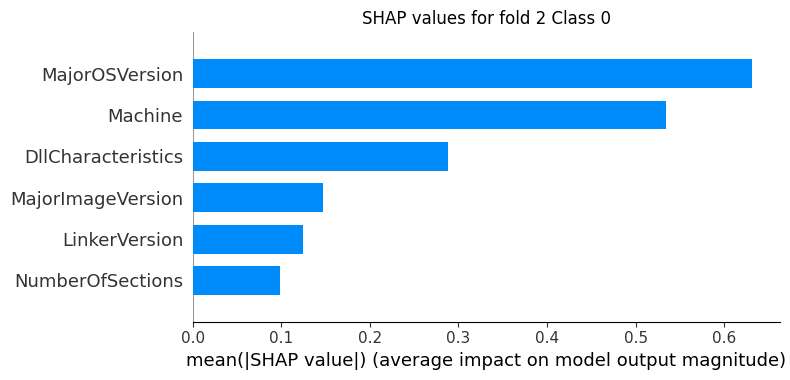

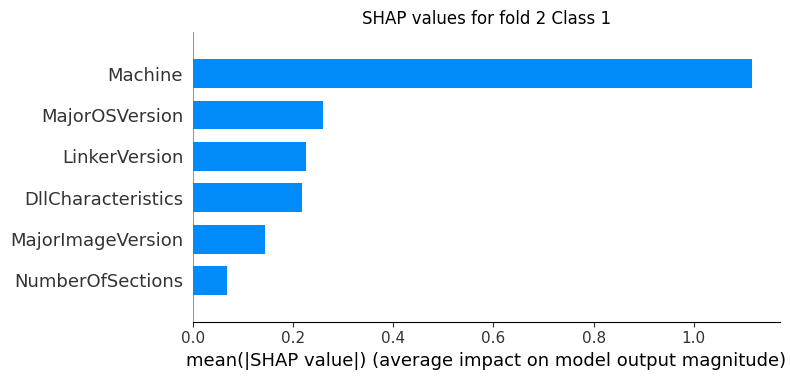

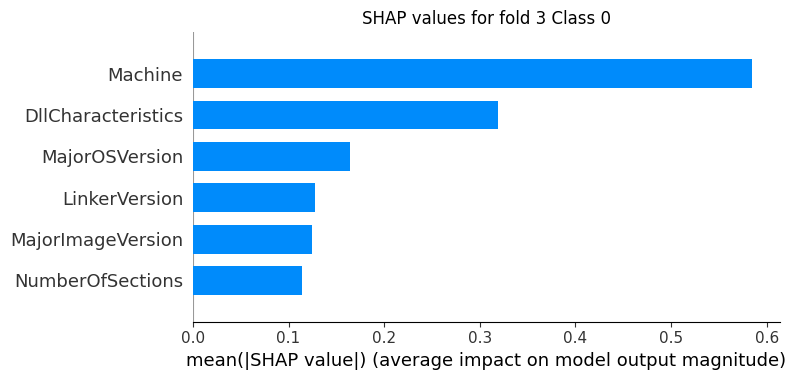

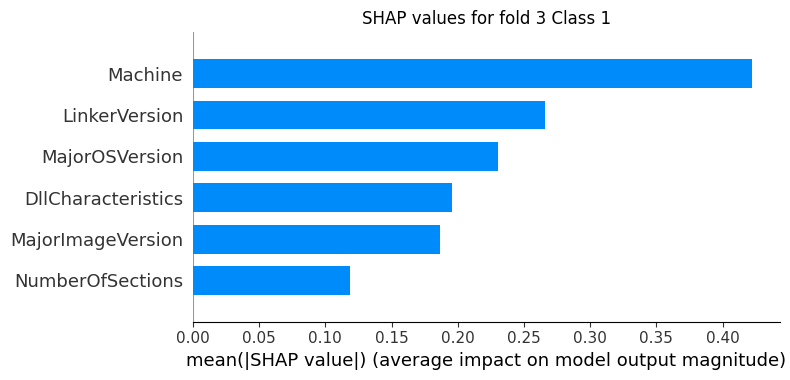

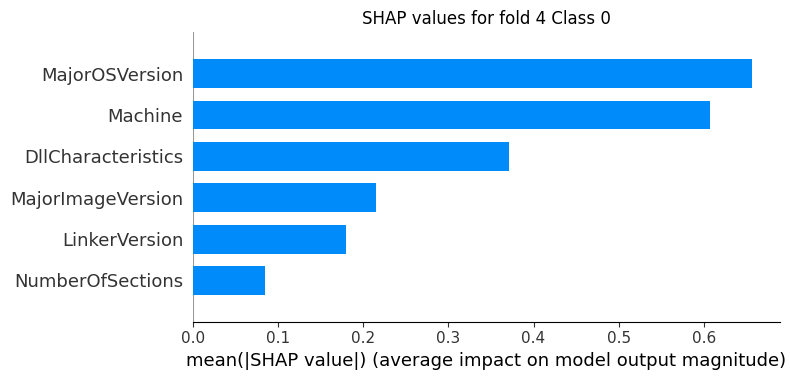

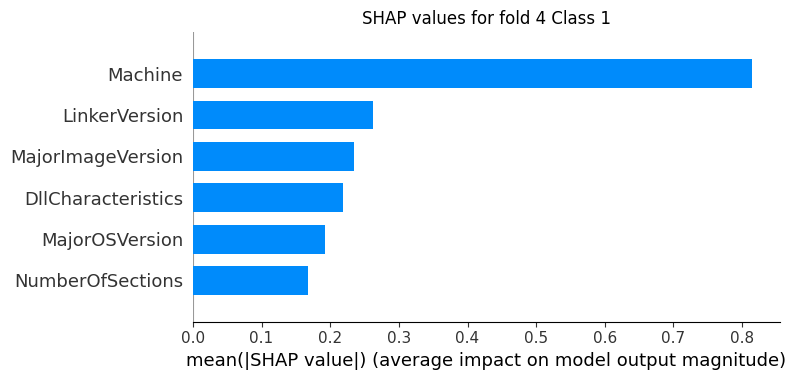

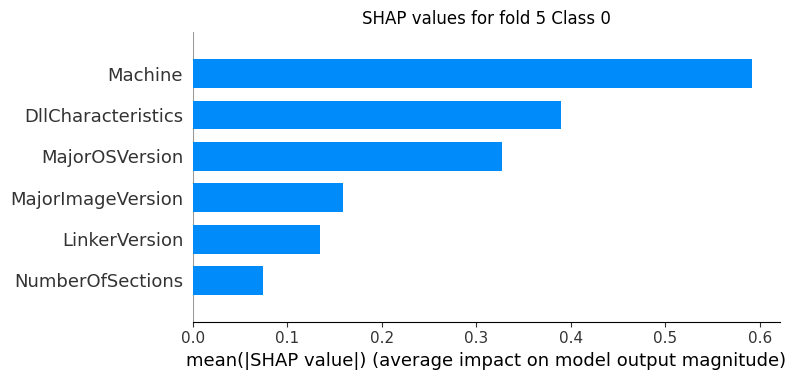

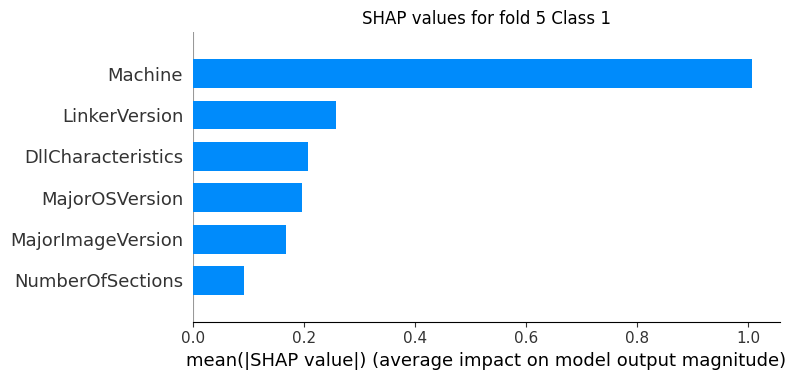

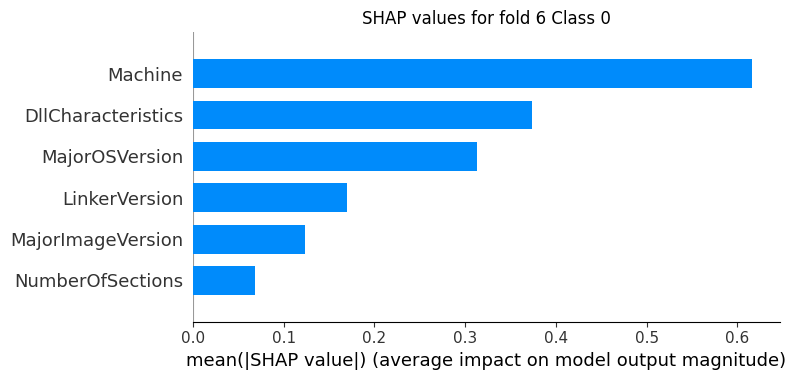

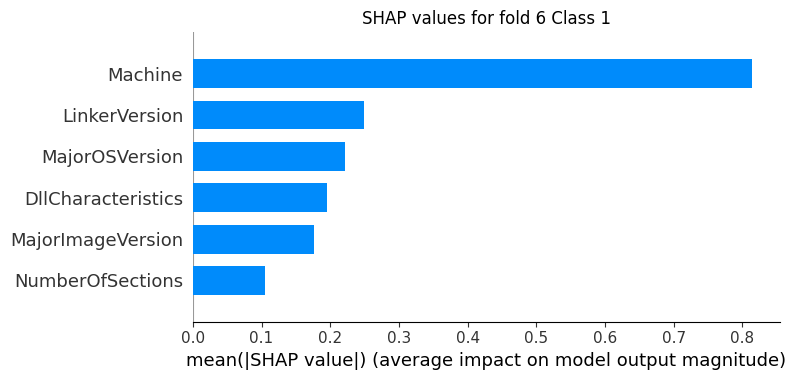

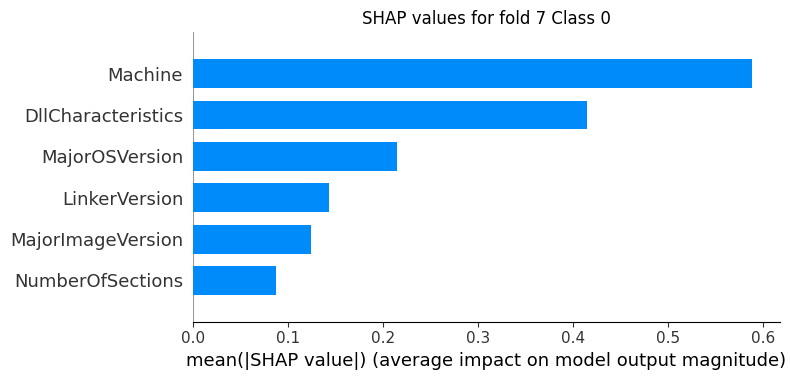

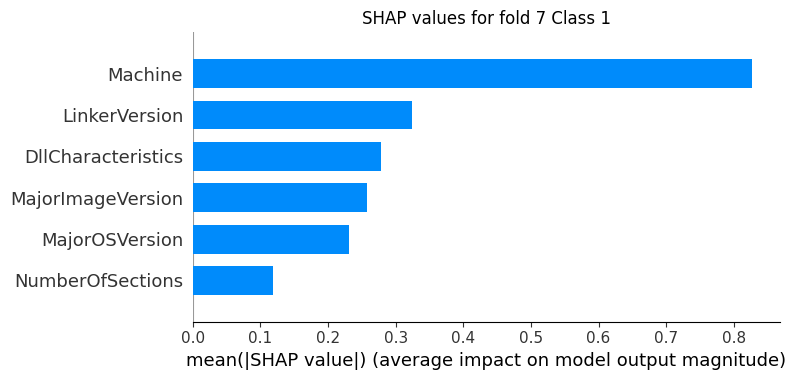

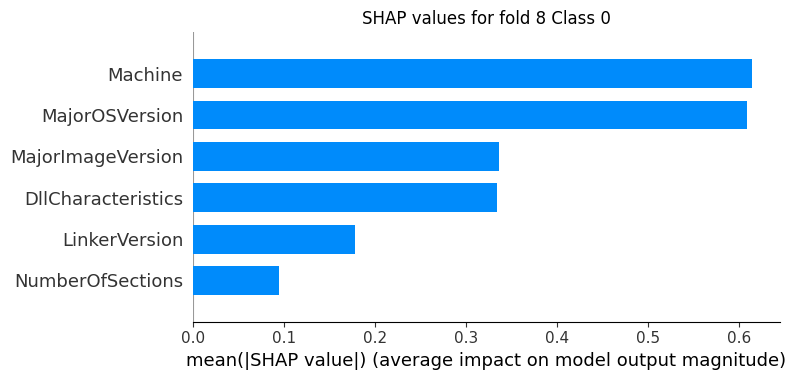

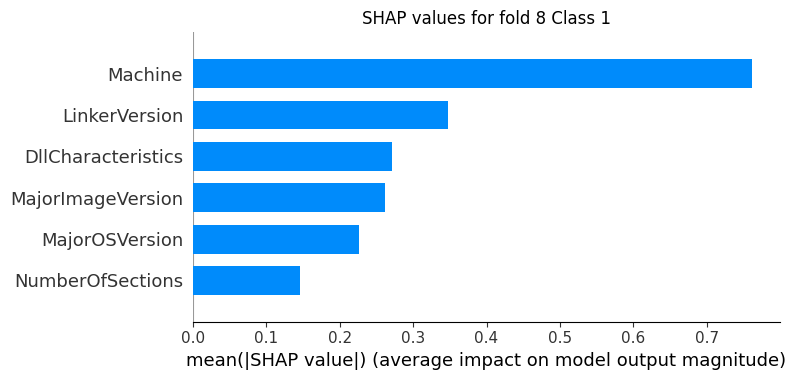

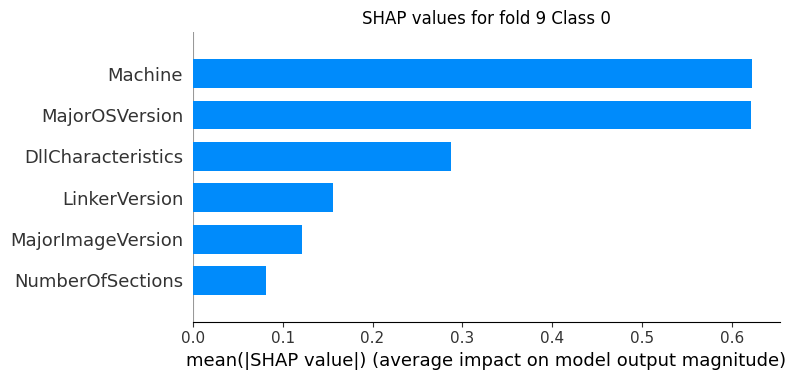

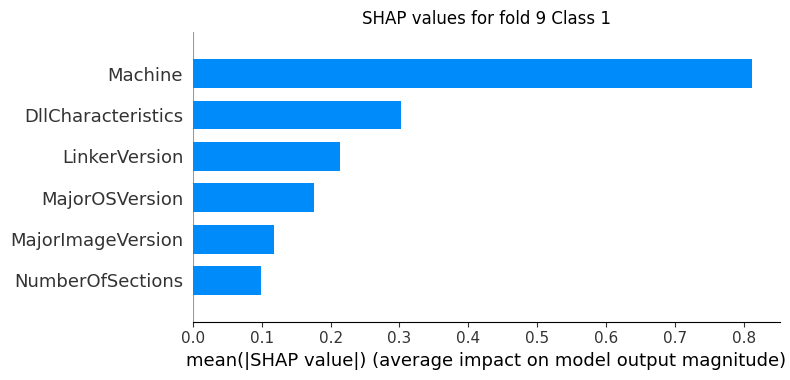

In [24]:
X = df[categorical_columns]  
y = df["Benign"]
 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transform", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)
 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
 


for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat_transform"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained LogisticRegression
    explainer = shap.Explainer(pipeline.named_steps["classifier"],pipeline.named_steps["preprocessor"].transform(X_test))
    shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_test))
 

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df = pd.DataFrame(shap_values.values, columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)

    # Initialization of dictionary to contain aggregate values 
    # class 0 -> ('Malicious', value 0)
    # class 1 -> ('Benign', value 1)
    agg_shap_per_row_class0 = []
    agg_shap_per_row_class1 = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap_class0 = {}
        row_agg_shap_class1 = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature considering that:
            # - Positive SHAP value means positive impact on prediction, leading the model to predict 1
            # - Negative SHAP value means negative impact, leading the model to predict 0.
            shap_values_class0 = row[enc_feats][row[enc_feats] < 0].mean()  # Media solo dei valori negativi (Classe 0)
            shap_values_class1 = row[enc_feats][row[enc_feats] > 0].mean()  # Media solo dei valori positivi (Classe 1)
            
            # Add aggregated results for class 0 and class 1
            if shap_values_class0 != 0:
                row_agg_shap_class0[orig_feat] = shap_values_class0
            if shap_values_class1 != 0:
                row_agg_shap_class1[orig_feat] = shap_values_class1
        
        # Add the aggrgated results to the correct list
        agg_shap_per_row_class0.append(row_agg_shap_class0)
        agg_shap_per_row_class1.append(row_agg_shap_class1)

    # Converts the list of aggregated results into a DataFrame for class 0 and class 1
    agg_shap_df_class0 = pd.DataFrame(agg_shap_per_row_class0)
    agg_shap_df_class0 = agg_shap_df_class0.fillna(0)
    agg_shap_df_class0 = agg_shap_df_class0.abs()

    agg_shap_df_class1 = pd.DataFrame(agg_shap_per_row_class1)
    agg_shap_df_class1 = agg_shap_df_class1.fillna(0)

    # Show the data frames 
    # print(f"FOLD {i}\n")
    # print("SHAP values for class 0:")
    # print(agg_shap_df_class0.head(20))
    # print("\nAggregated SHAP values for class 1:")
    # print(agg_shap_df_class1.head(20))


    plt.title(f"SHAP values for fold {i} Class 0")
    shap.summary_plot(agg_shap_df_class1.values, features=agg_shap_df_class1.columns, plot_type="bar")
    plt.show()
    plt.title(f"SHAP values for fold {i} Class 1")
    shap.summary_plot(agg_shap_df_class0.values, features=agg_shap_df_class0.columns, plot_type="bar")
    plt.show()
    


 
    

How SHAP is Used in This Code

This code applies SHAP to a Logistic Regression model trained on categorical data. Since the categorical features are transformed using One-Hot Encoding (OHE) before training, the SHAP values are initially computed for the encoded features. However, the goal is to understand the importance of the original categorical features before encoding, so the SHAP values for each feature’s one-hot encoded components are aggregated.

Step-by-Step Breakdown
Data Preprocessing and Model Training
The categorical features are extracted from the dataset.
A preprocessing pipeline is created using OneHotEncoder to transform categorical variables.
A Logistic Regression model is trained using 10-fold Stratified Cross-Validation.
Extracting One-Hot Encoded Feature Names
After training, the OneHotEncoder feature names are retrieved to understand how categorical features were expanded.
SHAP Explanation Computation
A SHAP explainer is initialized using the trained Logistic Regression model.
The SHAP values are computed for the transformed input data. These values indicate the contribution of each one-hot encoded feature to the model’s predictions.
Mapping SHAP Values Back to Original Features
Since each categorical feature was split into multiple one-hot encoded components, SHAP values for these components are aggregated (using the mean of absolute values).
This gives a single importance score per original categorical feature.
Visualization
A bar plot is generated using Seaborn, displaying SHAP feature importance for the original categorical features before encoding.
Colors are assigned based on feature names to enhance readability.

##### Test to see performances using only variables that appear to be the most important

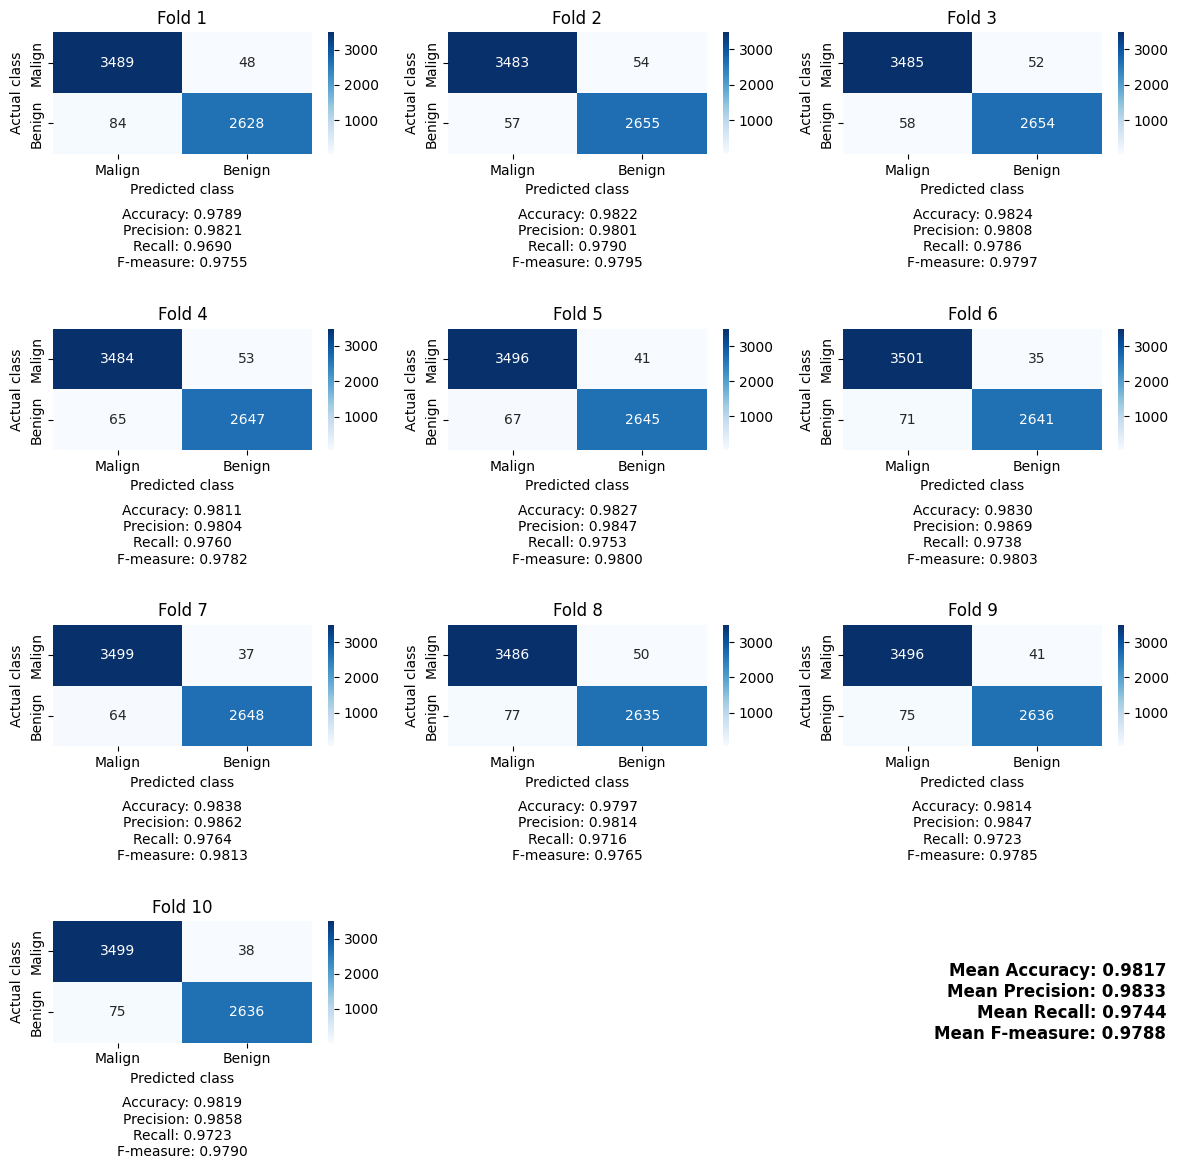

In [11]:
new_categorical_columns = ["Machine", "MajorOSVersion", "DllCharacteristics"]
X = df[new_categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), new_categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

f1_list_lr_cat = f1_list
accuracy_list_lr_cat = accuracy_list

#### Explainability of Random Forest

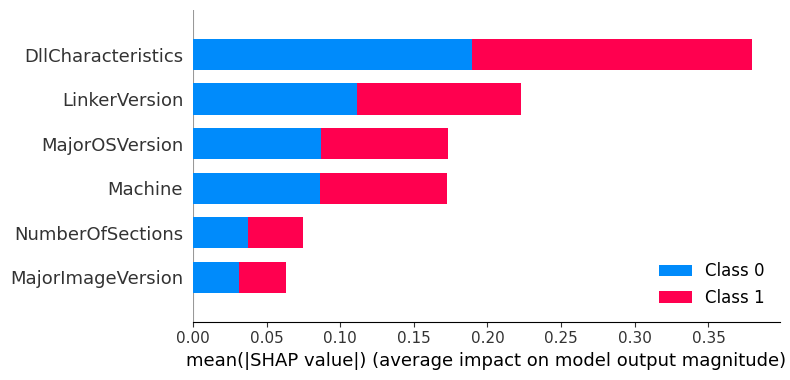

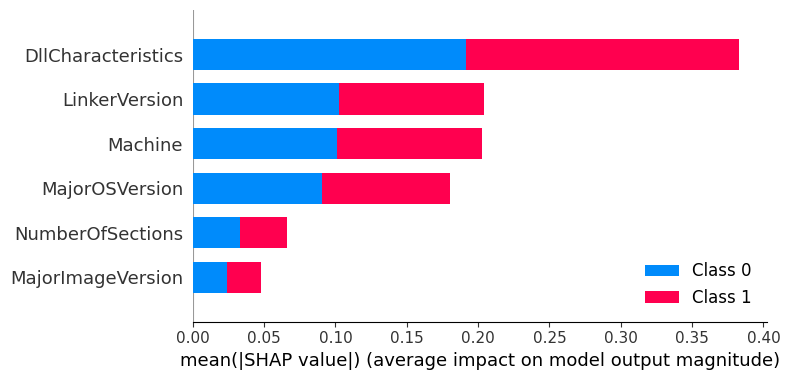

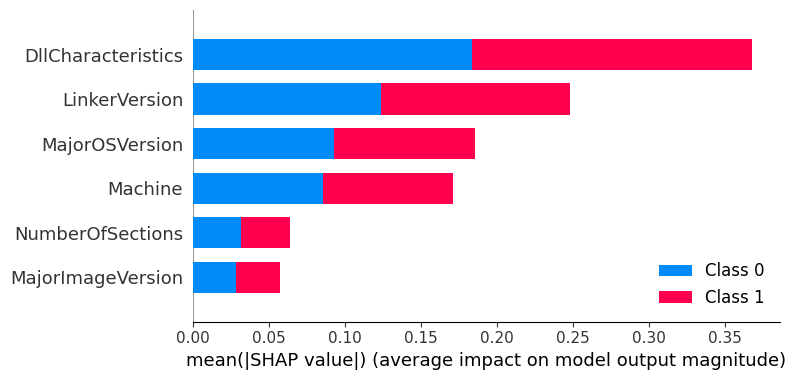

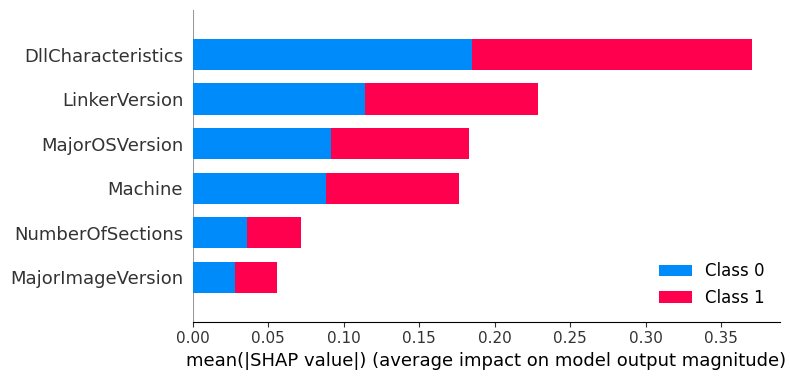

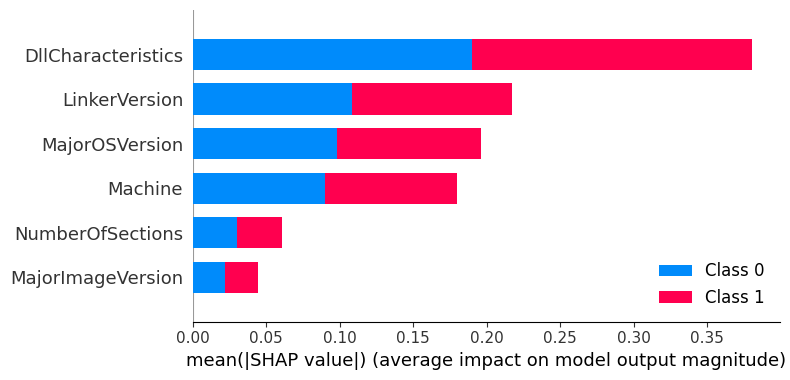

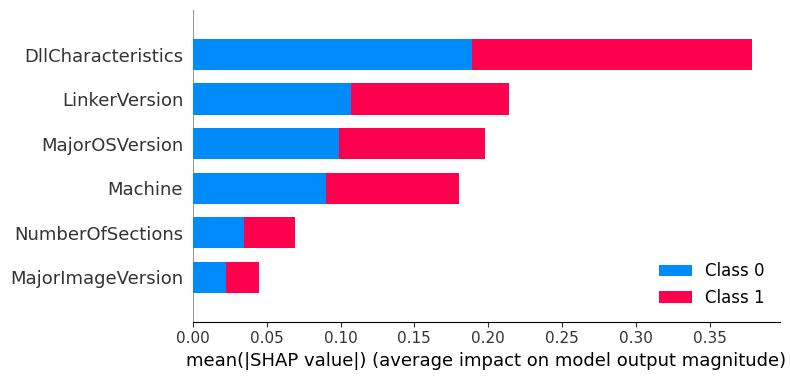

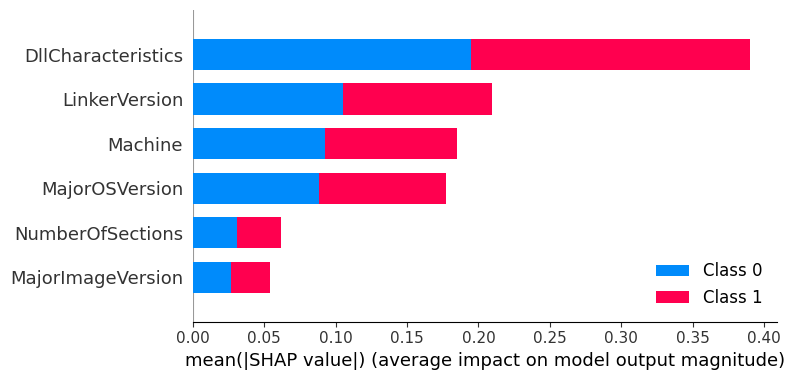

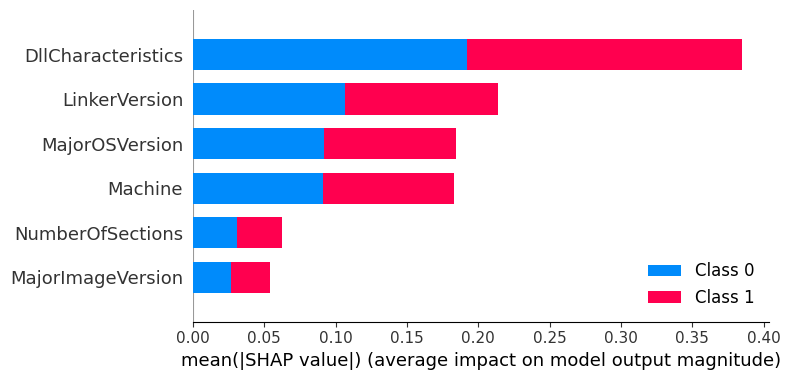

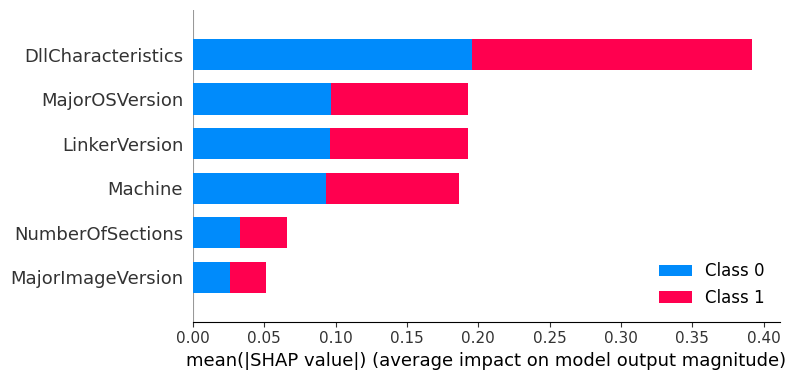

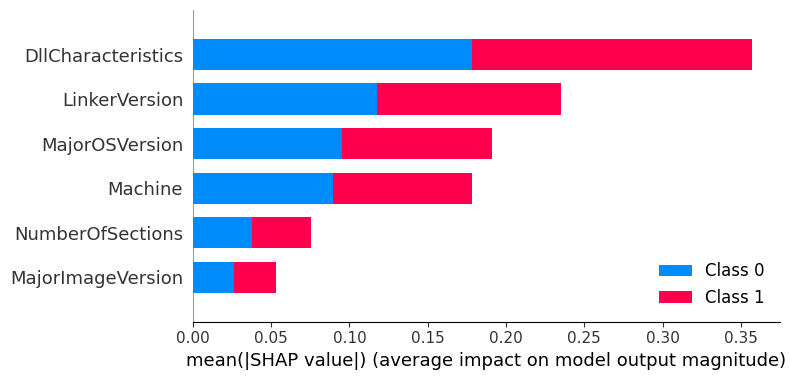

In [ ]:
X = df[categorical_columns]
y = df['Benign']


pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    model = pipeline.named_steps['classifier']  # trained model to be passed to the explainer

    # use SHAP to explain predictions
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    # nel caso di una classificazione binaria, shap_values è una lista che contiene due array bidimensionali: uno per ogni classe.
    # ogni array ha lo stesso numero di righe di X_test e un numero di colonne pari alle features, e ogni riga rappresenta
    # l'influenza di ciascuna feature sulla previsione di quella classe per l'istanza di test corrispondente.
    # - shap_values[0]: è un array di dimensione (n_samples, n_features) che contiene i valori SHAP per la classe 0.
    # - shap_values[1]: è un array di dimensione (n_samples, n_features) che contiene i valori SHAP per la classe 1.
   
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    







